# Lesson 5. Uncertainty Analysis

<b>Recommended preliminary knowledge:</b> Knowledge gained in lesson 3 and corresponding recommended preliminary knowledge. Furthermore, the user is encouraged to familiarize themselves with the Python package <i>lmfit</i>, which is useful for performing least-squared optimization.

Development of thermodynamic modelling functions: Xiaodong Liang<br>
Development of optimization functions: Daniel Qvistgaard<br>
Jupyter Notebook author: Daniel Qvistgaard

## 1. Introduction
In lesson 3 comparison functions were introduced. Comparison functions are helpful, because they return the deviation/error between the model and experimental data. In this chapter you will learn about parameter optimization using the CERE package, and at the heart of any parameter optimization is an <i>objective function</i>. Here the objective functions will contain the comparison functions we learned about in lesson 3.

## 2. Initialization
In order for any code blocks to properly work in this Jupyter Notebook, please run the following code block. This piece of code loads the CERE package containing thermodynamical functions. Furthermore, <i>Numpy</i> and <i>matplotlib</i> are loaded.

In [1]:
#from scipy.optimize import leastsq
from pythermo import pythermo as pt#Required
import numpy as np #Recommended
from matplotlib import pyplot as plt #Recommended - used for plotting
import pandas as pd #Recommended

## 3. Loading Data

Here we load pure component data for the compound Triethylene glycol (TEG).

In [2]:
#Here we initialize the class
exp_data = pt.Experimental_Data()

#By using the "Add" class function, we may add experimental data to the class. First we add vapor pressure data
filename_psat = 'experimental_data/TEG_vapor_pressure.csv'
datatype_psat = 'PSat'
identifier_psat = 'teg_psat'
exp_data.Add(filename_psat, datatype_psat, identifier_psat)

#Similarly, we add liquid density data.
filename_rho = 'experimental_data/TEG_liq_density.csv'
datatype_rho = 'rho'
identifier_rho = 'teg_rho'
exp_data.Add(filename_rho, datatype_rho, identifier_rho)



In [3]:
#It is common to limit the pure component data to a specific temperature range, typically expressed as an
#an interval of reduced temperatures. If we seek to remove data outside these region, we impose the interval by 
#using the ReducedTemperature function

Tr_min = 0.4 #Reduced temperature min
Tr_max = 0.9 #Reduced temperature max
Tc = 769.5 #Critical temprature [K]
exp_data.ReducedTemperature(Tr_min, Tr_max, Tc)

print("After adjusting for reduced temperature")
exp_data.Show_list()

After adjusting for reduced temperature
Data Type        Dim (r x c)     Name           
-------------------------------------------------------------
PSat             38x2            teg_psat       
rho              50x2            teg_rho        




## 4. Sensitivity Analysis
### 4.1 Using the module
Now that we have selected experimental data to use for the sensitivity analyisis, it is time to perform the actual uncertainty analysis. First we set up a CPA model, which is done below

In [4]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

#Here we define the dictionary to contain critical properties of TEG
TEG_Crit = {
    "Tc" : 769.5,
    "Pc" : 33.2,
    "Om" : 0.05
}

#Here we define the dictionary to contain the original TEG parameters (before any optimization)
params_original = {
    "b0" : 128.93,
    "Gamma" : 3622.5,
    "c1" : 0.9100,
    "AssocVol" : 20.0,
    "AssocEng" : 1420.0,
}

AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1, TEG_Crit["Tc"], TEG_Crit["Pc"], TEG_Crit["Om"])
Thermo.CPAParams(1, params_original["b0"], params_original["Gamma"], params_original["c1"])
Thermo.AssocParams(1, AssocSch, params_original["AssocVol"], params_original["AssocEng"])

Now that a model have been set up, we can use the Uncertainty_Analysis class to perform sensitivity analysis.

In [5]:
#First an Uncertainty Analysis object is created
Uncertainty_Analysis = pt.Uncertainty_Analysis()

#Using the subfunction Add_Model, we can add the previously defined model to the object
Uncertainty_Analysis.Add_Model(Thermo)

#Using the subfunction Add_Experimental_Data, we can add the previously defined experimental data to the object
Uncertainty_Analysis.Add_Experimental_Data(exp_data)

#We are now ready to run sensitivity analysis.
(psat_deviation, rho_deviation, deltas) = Uncertainty_Analysis.Sensitivity_Analysis()

#psat_deviationn: Five column matrix, each column represents the deviations between model and psat data 
#measured at a change in one variable.
#Col 1: b0 [%]
#Col 2: Gamma [%]
#Col 3: c1 [%]
#Col 4: beta [%]
#Col 5: epsr [%]

#deltas: One column vector, each row represents a percent deviation from original parameter value.

The sensitivity analysis calculations have now been performed, and the results may be plotted.

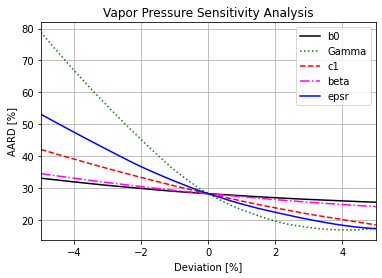

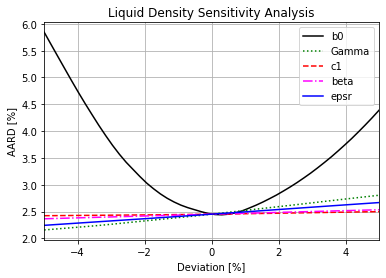

In [6]:
colors = ["black", "green", "red", "magenta",  "blue"]

linestyles = ['-',':','--','-.','-']

for i in range(0,5):
    plt.plot(deltas,psat_deviation[:,i],color=colors[i],linestyle=linestyles[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Vapor Pressure Sensitivity Analysis")
plt.show()



for i in range(0,5):
    plt.plot(deltas,rho_deviation[:,i],color=colors[i],linestyle=linestyles[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Liquid Density Sensitivity Analysis")
plt.show()

### 4.2 Use Case
Now that we have established how to perform sensitivity analysis with the Python module, let us look at an interesting use case. From the sensitivity analysis above we can visually see that the parameters are not stable, which is especially true for the vapor pressure predictions. These parameters correspond to the original TEG 6D parameters, which were optimized upon in Lecture 4. Let us perform this optimization once again, and see how the resulting parameters react to sensitivity analysis.

Optimization of the TEG parameters is performed below in the exact same manner as Lecture 4.

In [7]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1, TEG_Crit["Tc"], TEG_Crit["Pc"], TEG_Crit["Om"])
Thermo.CPAParams(1, params_original["b0"], params_original["Gamma"], params_original["c1"])
Thermo.AssocParams(1, AssocSch, params_original["AssocVol"], params_original["AssocEng"])

#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now the optimizer have enough information to perform parameterization.
params_optimized = optimizer.Optimization()

 

We have now obtained optimized parameters! Let us expose them to sensitivity analysis, just like the previous parameter set.

In [8]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()



Thermo.NoPureComp(1)
Thermo.CritProps(1, TEG_Crit["Tc"], TEG_Crit["Pc"], TEG_Crit["Om"])
Thermo.CPAParams(1, params_optimized["b0"], params_optimized["Gamma"], params_optimized["c1"])
Thermo.AssocParams(1, AssocSch, params_optimized["AssocVol"], params_optimized["AssocEng"])

#An uncertainty analysis object is created
Uncertainty_Analysis = pt.Uncertainty_Analysis()

#The following function is an optional functions, which allows us to set the upper and lower bounds for the sensitivity
#analysis in percentage deviation of original parameter. The default values are -5% and 5%. Try to switch them up!
Uncertainty_Analysis.Set_Delta(-5,5)

#Now we add the model to the uncertainty analysis object
Uncertainty_Analysis.Add_Model(Thermo)

#Now we add the experimental data to the uncertainty analysis object
Uncertainty_Analysis.Add_Experimental_Data(exp_data)

#Sensitivity analysis is run below
(psat_deviation, rho_deviation, deltas) = Uncertainty_Analysis.Sensitivity_Analysis()


The sensitivity analysis calculations have now been performed, and the results may be plotted.

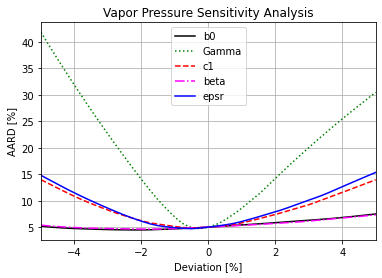

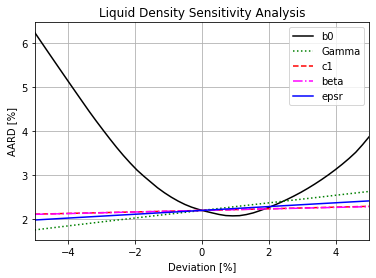

In [9]:
colors = ["black", "green", "red", "magenta",  "blue"]

linestyles = ['-',':','--','-.','-']

for i in range(0,5):
    plt.plot(deltas,psat_deviation[:,i],color=colors[i],linestyle=linestyles[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Vapor Pressure Sensitivity Analysis")
plt.show()

for i in range(0,5):
    plt.plot(deltas,rho_deviation[:,i],color=colors[i],linestyle=linestyles[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Liquid Density Sensitivity Analysis")
plt.show()

We see that the optimized parameters are more stable than the original parameters.

## 5. Bootstrapping
In this section the bootstrapping methodology is applied to test parameter uncertainties. Bootstrapping yields useful data, such as parameter confidence intervals and mutual linearity relationships.

In [10]:
#WARNING - This code section may take a long time to compute. For the purpose of showing an example,
#keep the number of iterations low
n_iterations = 100


#First, the thermodynamic calculations must be set up as per usual
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1, TEG_Crit["Tc"], TEG_Crit["Pc"], TEG_Crit["Om"])
Thermo.CPAParams(1, params_optimized["b0"], params_optimized["Gamma"], params_optimized["c1"])
Thermo.AssocParams(1, AssocSch, params_optimized["AssocVol"], params_optimized["AssocEng"])


Uncertainty_Analysis = pt.Uncertainty_Analysis()


Uncertainty_Analysis.Add_Model(Thermo)


Uncertainty_Analysis.Add_Experimental_Data(exp_data)



data_matrix = Uncertainty_Analysis.Bootstrapping(n_iterations, enable_counter = True)

Iteration 1 of 100
Iteration 2 of 100
Iteration 3 of 100
Iteration 4 of 100
Iteration 5 of 100
Iteration 6 of 100
Iteration 7 of 100
Iteration 8 of 100
Iteration 9 of 100
Iteration 10 of 100
Iteration 11 of 100
Iteration 12 of 100
Iteration 13 of 100
Iteration 14 of 100
Iteration 15 of 100
Iteration 16 of 100
Iteration 17 of 100
Iteration 18 of 100
Iteration 19 of 100
Iteration 20 of 100
Iteration 21 of 100
Iteration 22 of 100
Iteration 23 of 100
Iteration 24 of 100
Iteration 25 of 100
Iteration 26 of 100
Iteration 27 of 100
Iteration 28 of 100
Iteration 29 of 100
Iteration 30 of 100
Iteration 31 of 100
Iteration 32 of 100
Iteration 33 of 100
Iteration 34 of 100
Iteration 35 of 100
Iteration 36 of 100
Iteration 37 of 100
Iteration 38 of 100
Iteration 39 of 100
Iteration 40 of 100
Iteration 41 of 100
Iteration 42 of 100
Iteration 43 of 100
Iteration 44 of 100
Iteration 45 of 100
Iteration 46 of 100
Iteration 47 of 100
Iteration 48 of 100
Iteration 49 of 100
Iteration 50 of 100
Iteration

### 5.1. Parameter Distributions
Now that bootstrapping calculations have been run, a data matrix is acquired. Each column of the data matrix represent a parameter, and each row represents the optimized parameter value for a given iteration. This means that data_matrix is of size (r = num. of it., c = num. of params.). A number of useful information may be obtained from these distrubutions. Below we will make a histogram of each column, to get an idea of the parameter distribution.

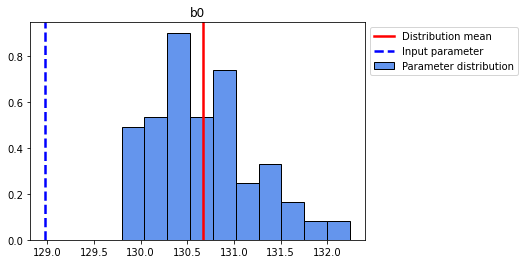

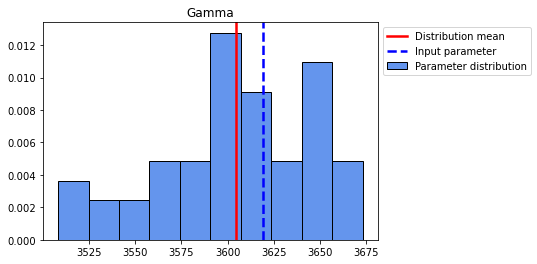

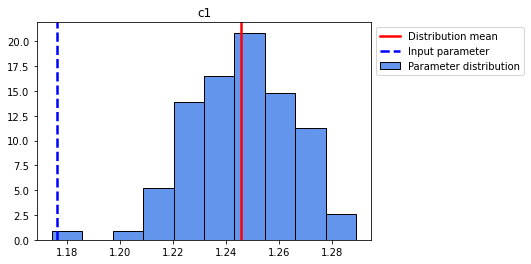

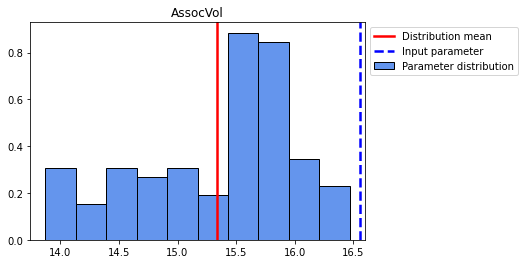

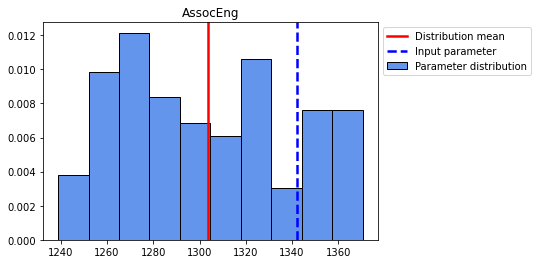

In [11]:
titles = ["b0","Gamma","c1", "AssocVol", "AssocEng"]

for i in range(0,5):
    plt.hist(data_matrix[:,i], density = 1, edgecolor = 'black',color = 'cornflowerblue', label = "Parameter distribution")
    plt.axvline(np.mean(data_matrix[:,i]),LineWidth = 2.5, color = 'red', label = "Distribution mean") #Line indicating the average parameter value
    plt.axvline(params_optimized[titles[i]],LineWidth = 2.5, color = 'blue',LineStyle = '--', label = "Input parameter") #Line indicating the average parameter value
    plt.title(titles[i])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

### 5.2 Parameter Mutual Linear Relationships
Bootstrapping may reveal that two or more parameters are linearly dependent on each other. To test for this, one should simply create a scatter plot of one parameter distribution against another. In reality, one could simply plot one column of data_matrix against another, but to make this process simpler a function called Scatter_Plots may be utilized, which is a part of the Uncertainty_Analysis object. By feeding the data_matrix into the function, it returns a dictionary containing each paramater combination as a two column matrix. 

In [12]:
outputs = Uncertainty_Analysis.Scatter_Plots(data_matrix) #Feed data_matrix, and receive a dictionary as output
print(outputs.keys()) #Now we print all the keys of the dictionary, notice the output below to see the available combinations

dict_keys(['b0_vs_Gamma', 'b0_vs_c1', 'b0_vs_beta', 'b0_vs_eps', 'Gamma_vs_c1', 'Gamma_vs_beta', 'Gamma_vs_eps', 'c1_vs_beta', 'c1_vs_eps', 'beta_vs_eps'])


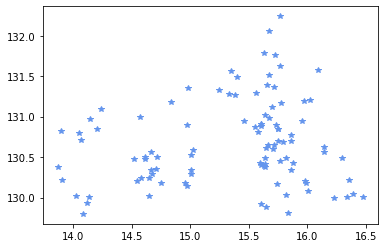

In [13]:
#Let's say we are interested in testing the linear relationship between the  parameters b0 and beta. To do this, 
#simply enter the corresponding key (from the print above) into the dictionary, and you will get an output consisting of
#a two column matrix with b0 distribution and beta distribution

matrix = outputs["b0_vs_beta"]


#Now we simply plot the two columns against each other in a scatter plot
plt.plot(matrix[:,0], matrix[:,1],'*',color='cornflowerblue')
plt.show()


Depending on the number of iterations used for the bootstrapping, it may or may not be apparent above whether a linear relationship exist. If one wants to test every possible parameter combination for linearity, the following snippet of code may be run

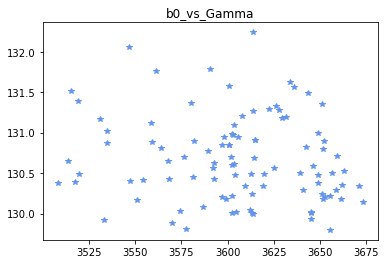

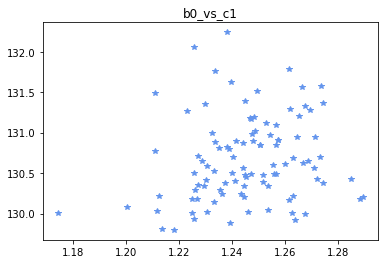

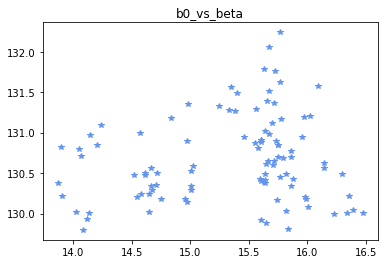

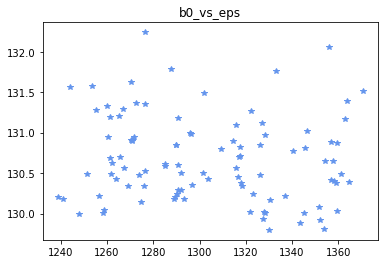

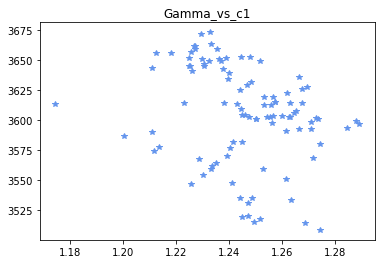

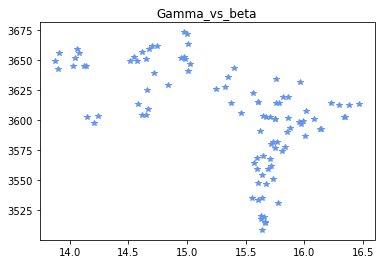

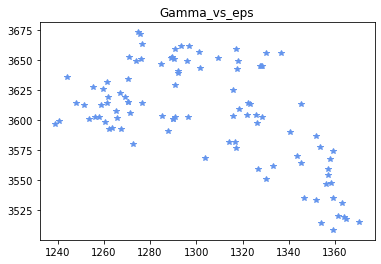

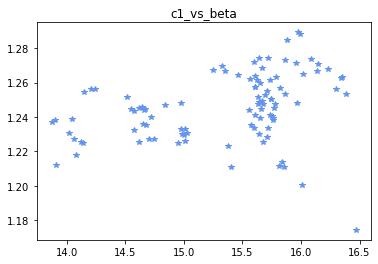

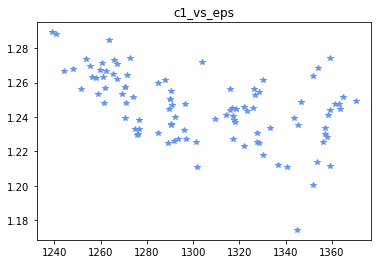

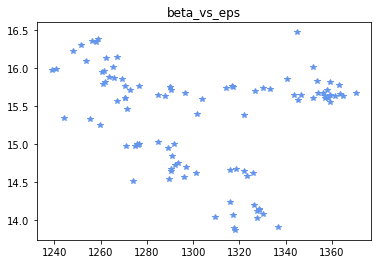

In [14]:
for str, values in outputs.items():
    plt.plot(values[:,0],values[:,1],'*',color='cornflowerblue')
    plt.title(str)
    plt.show()